# Version description
- Added DART as HP option
- Rank Ascending = False
- Use selected feautres in v24

In [1]:
# import libraries
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
from os.path import isfile, isdir, join
import numpy as np
import pandas as pd
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
import re
from IPython.display import display
from zipfile import ZipFile
import pickle
import unicodedata
import pytz
from joblib import Parallel, delayed
import shutil
import difflib
import random
import math
from shutil import copyfile
import itertools
import time
from tqdm import tqdm
import collections
from collections import deque
import gc

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.metrics import ndcg_score, accuracy_score, mean_squared_error

import lightgbm as lgbm
import optuna
from optuna import Trial, visualization

import matplotlib as mpl
from matplotlib import pyplot as plt

import jpx_tokyo_market_prediction

from utility_script import *
# from utility_script_jpx import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
'''
Notebook Parameters
'''
# basic
SEED = 0
JPX_PATH = '../input/jpx-tokyo-stock-exchange-prediction'

# data sacling
SCALER = StandardScaler()
SCALE_DAILY = False

# PCA
RUN_PCA = False
N_COMP = 0.9

# target definition
RANK_ASCENDING = False # set this to False if model prediction is same direction of Target
TARGET_POW = 0

# data split
N_FOLD = 5
TRN_SIZE = 240
VAL_SIZE = 60
TRN_VAL_GAP = 14
SPLIT_METHOD = 'trn_val_split_late_val'

# model fixed params
DEVICE_TYPE = 'CPU'
EVAL_AT = 2000
LABEL_GAIN = 1.01**np.arange(2000)
EVAL_METRIC = f'ndcg@{EVAL_AT}'
LGBM_VAR_PARAMS = dict(
    boosting_type = 'gbdt',
    max_depth = 32,
    num_leaves = 32,
    learning_rate = 0.01,
    min_child_weight = 0.1,
    min_child_samples = 1,
    subsample = 0.65,
    subsample_freq = 1,
    colsample_bytree = 0.6,
    reg_alpha = 1.5,
    reg_lambda = 1.5,
    max_bin = 255,
    objective = 'lambdarank',
)
LGBM_FIXED_PARAMS = dict(
    n_estimators = 5000,
    label_gain = LABEL_GAIN,
    n_jobs = -1,
    random_state = SEED,
    device_type = DEVICE_TYPE,
)

# feature importance
RUN_IMP = False
N_SHUFFLE = 12
N_FEATS_IMP_TEST = 10
N_ESTIMATORS_IMP = 50
EARLY_STOPPING_ROUNDS_IMP = 9999
FEAT_GROUPS = None # fixed output if not running IMP

# forward selection
RUN_FS = False
N_ESTIMATORS_FS = 5000
EARLY_STOPPING_ROUNDS_FS = 20
N_FEATS_FS = 20 # top N features considered for FS based on importance
N_FEATS_FINAL = None # top N features if skipping FS based on importance
SELECTED_FEATS = 'OperatingProfit_pctg, ForecastOrdinaryProfit_pctg, BookValuePerShare_pctg, ForecastEarningsPerShare_pctg'.split(', ') # fixed features if skipping both IMP and FS

# hyperparameters tuning
RUN_HP = True
N_ESTIMATORS_HP = 5000
EARLY_STOPPING_ROUNDS_HP = 30
HP_OPT_HRS = 4
BEST_PARAMS = None

# re-fit
N_ESTIMATORS_REFIT = 5000
EARLY_STOPPING_ROUNDS_REFIT = 30

# Data preprocessing

In [3]:
'''
Train-Val split where validation periods are right after train period
'''
def trn_val_split_even_val(features, val_to_end):
    # define start date of each fold
    fold_dates = features.Date.drop_duplicates().reset_index(drop=True)
    fold_dates = fold_dates.shift(TRN_SIZE + TRN_VAL_GAP + VAL_SIZE).loc[lambda x: x.notnull()].reset_index(drop=True)
    fold_dates = fold_dates.loc[np.linspace(0, fold_dates.shape[0]-1, N_FOLD).astype(int)].reset_index(drop=True)

    # create and append train + val data
    full_dates = features.Date.drop_duplicates().reset_index(drop=True)
    full_data = []
    for i, date in enumerate(fold_dates):
        dates_trn = full_dates.loc[lambda x: x>=date].head(TRN_SIZE)
        if val_to_end==False:
            dates_val = full_dates.loc[lambda x: x>=date].shift(-TRN_SIZE).shift(-TRN_VAL_GAP).head(VAL_SIZE)
        else:
            dates_val = full_dates.loc[lambda x: x>=date].shift(-TRN_SIZE).shift(-TRN_VAL_GAP).loc[lambda x: x.notnull()]
        full_data.append(features.loc[lambda x: x.Date.isin(dates_trn)].assign(fold=i, trn_val='trn'))
        full_data.append(features.loc[lambda x: x.Date.isin(dates_val)].assign(fold=i, trn_val='val'))
    full_data = pd.concat(full_data).reset_index(drop=True)
    return full_data


'''
Train-Val split where validation periods are farthest in future
'''
def trn_val_split_late_val(features, val_to_end):
    # define start date of each fold
    fold_dates = features.Date.drop_duplicates().reset_index(drop=True)
    fold_dates = fold_dates.shift(TRN_SIZE + TRN_VAL_GAP + VAL_SIZE).loc[lambda x: x.notnull()].reset_index(drop=True)
    fold_dates = fold_dates.loc[np.linspace(0, fold_dates.shape[0]-1, N_FOLD).astype(int)].reset_index(drop=True)

    # create and append train + val data
    full_dates = features.Date.drop_duplicates().reset_index(drop=True)
    val_dates_list = full_dates.tail(VAL_SIZE * N_FOLD).values.reshape(N_FOLD, -1)
    full_data = []
    for i, date in enumerate(fold_dates):
        dates_trn = full_dates.loc[lambda x: x>=date].head(TRN_SIZE)
        if val_to_end==False:
            dates_val = val_dates_list[i]
        else:
            dates_val = np.concatenate(val_dates_list[i:])
        full_data.append(features.loc[lambda x: x.Date.isin(dates_trn)].assign(fold=i, trn_val='trn'))
        full_data.append(features.loc[lambda x: x.Date.isin(dates_val)].assign(fold=i, trn_val='val'))
    full_data = pd.concat(full_data).reset_index(drop=True)
    return full_data

In [4]:
'''
Function to scale the features
'''
def jpx_data_scaling(full_data, scaler, daily):
    feats = time_features + stock_features
    
    if daily==False:
        data_scaled = []
        for fold in range(N_FOLD):
            # locate train and val datasets
            data_trn = full_data.loc[lambda x: (x.fold==fold) & (x.trn_val=='trn')]
            data_val = full_data.loc[lambda x: (x.fold==fold) & (x.trn_val=='val')]
            # fit scaler
            scaler = scaler.fit(data_trn[feats])
            save_pkl(scaler, f'scaler{fold}')
            # transform data
            data_trn[feats] = scaler.transform(data_trn[feats]).astype(np.float32)
            data_val[feats] = scaler.transform(data_val[feats]).astype(np.float32)
            # store transformed data
            data_scaled.append(data_trn)
            data_scaled.append(data_val)
        data_scaled = pd.concat(data_scaled).reset_index(drop=True)
            
    elif daily==True:
        # scale stock features for each day
        def transform_data(df, scaler, feats):
            df[feats] = scaler.fit_transform(df[feats]).astype(np.float32)
            return df
        full_data = full_data.groupby(['fold','trn_val','Date']).apply(lambda df: transform_data(df, scaler, stock_features))
        # then scale time features across days
        data_scaled = []
        for fold in range(N_FOLD):
            # locate train and val datasets
            data_trn = full_data.loc[lambda x: (x.fold==fold) & (x.trn_val=='trn')]
            data_val = full_data.loc[lambda x: (x.fold==fold) & (x.trn_val=='val')]
            # fit scaler
            scaler = scaler.fit(data_trn[time_features])
            save_pkl(scaler, f'scaler{fold}')
            # transform data
            data_trn[time_features] = scaler.transform(data_trn[time_features]).astype(np.float32)
            data_val[time_features] = scaler.transform(data_val[time_features]).astype(np.float32)
            # store transformed data
            data_scaled.append(data_trn)
            data_scaled.append(data_val)
        data_scaled = pd.concat(data_scaled).reset_index(drop=True)
        
    return data_scaled

In [5]:
'''
PCA Compression
'''
def pca_compress(full_data):
    # fit with one fold of traiing data
    pca = PCA(n_components=N_COMP, random_state=SEED)
    pca.fit(full_data.loc[lambda x: (x.fold==0) & (x.trn_val=='trn'), all_features])
    print(f'PCA shape of components: {pca.components_.shape}')
    
    # tranform the full dataset
    cols = [f'pc{x}' for x in range(pca.components_.shape[0])]
    compressed_data = []
    for fold in range(N_FOLD):
        for trn_val in ['trn','val']:
            X = pd.DataFrame(pca.transform(full_data.loc[lambda x: (x.fold==fold) & (x.trn_val==trn_val), all_features]), columns=cols)
            header = full_data.loc[lambda x: (x.fold==fold) & (x.trn_val==trn_val), [c for c in full_data.columns if c not in all_features]].reset_index(drop=True)
            new_df = pd.concat([header, X], axis=1)
            compressed_data.append(new_df)
    compressed_data = pd.concat(compressed_data, axis=0).reset_index(drop=True)
    return compressed_data, cols

# Model Training Functions

In [6]:
'''
Function to get sub-columns from table for model fitting
'''
def get_dataset(df, selected_feats, trn_val):
    if trn_val=='val':
        df = df.groupby('Date').sample(frac=1.0, random_state=SEED)
    df = df.reset_index(drop=True)
    grp = df.groupby('Date').size().tolist()
    qid = df['Date']
    X = df[selected_feats]
    y = df['target_train']
    target = df['Target']
    header = df[id_cols]
    return X, y, grp, qid, header, target

'''
Function to predict scores within groups
'''
def pred_score(model, X, qid):
    X_ = X.assign(Date=qid)
    score = []
    for date in X_.Date.unique():
        score += pd.Series(model.predict(X_.loc[lambda x: x.Date==date].drop('Date',axis=1))).tolist()
    return pd.Series(score)

'''
Function to predict rankings within groups
'''
def pred_rank(model, X, qid):
    X_ = X.assign(Date=qid)
    rnk = []
    for date in X_.Date.unique():
        rnk += pd.Series(model.predict(X_.loc[lambda x: x.Date==date].drop('Date',axis=1))).rank(method='first').tolist()
    return pd.Series(rnk)

'''
Function to transform model output to rank prediction table
'''
def get_pred_df(header, pred_model, y_true_train, y_true, rank_ascending):
    df_pred = pd.concat([header[['RowId','Date','SecuritiesCode']].assign(Date=lambda x: x.Date.dt.strftime('%Y-%m-%d'), SecuritiesCode=lambda x: x.SecuritiesCode.astype(int)).reset_index(drop=True),
                        pd.Series(pred_model).rename('pred_model').reset_index(drop=True),
                        y_true_train.reset_index(drop=True),
                        y_true.reset_index(drop=True)
                        ], axis=1)
    df_pred['Rank'] = df_pred.groupby('Date').pred_model.rank(method='first', ascending=rank_ascending).astype(int) - 1
    return df_pred

'''
Official function to calculate Sharpe Ratio given a prediction
'''
def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
    assert df['Rank'].min() == 0
    assert df['Rank'].max() == len(df['Rank']) - 1
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
    short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
    return purchase - short

def my_calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
    assert df['Rank'].min() == 0
    assert df['Rank'].max() == len(df['Rank']) - 1
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
    short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
    return pd.DataFrame({'long':[purchase],'short':[short],'net':[purchase - short]})

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

In [7]:
'''
Training function
'''
def train_model(fold, params, mode):
    # unpack model params
    selected_feats = params['selected_feats']
    lgbm_var_params = params['lgbm_var_params']
    lgbm_fixed_params = params['lgbm_fixed_params']
    lgbm_fixed_params['n_estimators'] = params['n_estimators']
    early_stopping_rounds = params['early_stopping_rounds']

    # define dataset
    data_trn = full_data.loc[lambda x: (x.fold==fold) & (x.trn_val=='trn')]
    data_val = full_data.loc[lambda x: (x.fold==fold) & (x.trn_val=='val')]
    X_trn, y_trn, grp_trn, qid_trn, header_trn, target_trn = get_dataset(data_trn, selected_feats, 'trn')
    X_val, y_val, grp_val, qid_val, header_val, target_val = get_dataset(data_val, selected_feats, 'val')
    # model fit
    model = lgbm.LGBMRanker(**lgbm_fixed_params, **lgbm_var_params)
    model.fit(
        X = X_trn,
        y = y_trn,
        group = grp_trn,
        eval_set = [(X_val, y_val)],
        eval_group = [grp_val],
        eval_names = ['Validation'],
        eval_at = EVAL_AT,
        verbose = False,
        eval_metric = EVAL_METRIC,
        early_stopping_rounds = early_stopping_rounds
    )

    # output
    if mode == 'val_score_only':
        output = model.best_score_['Validation'][EVAL_METRIC] * -1 # this score is for minimization problem
        
    if mode == 'val_sharpe_only':
        pred_val = pred_rank(model, X_val, qid_val)
        df_pred_val = get_pred_df(header_val, pred_val, y_val, target_val, RANK_ASCENDING)
        sharpe_val = calc_spread_return_sharpe(df_pred_val)
        output = sharpe_val * -1 # this score is for minimization problem
        
    if mode == 'feat_imp':
        model.set_params(importance_type='gain')
        imp_gain = model.feature_importances_
        model.set_params(importance_type='split')
        imp_split = model.feature_importances_
        output = pd.concat([
            pd.DataFrame({'feat':model.feature_name_, 'imp':imp_gain}).assign(imp_type='gain', imp=lambda x: x.imp.rank()),
            pd.DataFrame({'feat':model.feature_name_, 'imp':imp_split}).assign(imp_type='split', imp=lambda x: x.imp.rank())
        ], axis=0).assign(fold=fold)
    
    if mode == 'normal':
        # save model
        save_pkl(model, f"model{fold}")
        # number of distinct predicted values
#         n_uniq = pd.Series(model.predict(X_trn)).nunique()
        n_uniq_trn = pd.concat([pred_score(model, X_trn, qid_trn).rename('score'), header_trn], axis=1).groupby('Date').score.nunique().mean()
        n_uniq_val = pd.concat([pred_score(model, X_val, qid_val).rename('score'), header_val], axis=1).groupby('Date').score.nunique().mean()
        # prediction
        pred_trn = pred_rank(model, X_trn, qid_trn)
        pred_val = pred_rank(model, X_val, qid_val)
        # prediction df
        df_pred_trn = get_pred_df(header_trn, pred_trn, y_trn, target_trn, RANK_ASCENDING)
        df_pred_val = get_pred_df(header_val, pred_val, y_val, target_val, RANK_ASCENDING)
        # sharpe
        sharpe_trn = calc_spread_return_sharpe(df_pred_trn)
        sharpe_val = calc_spread_return_sharpe(df_pred_val)
        # output dict
        output = dict(
            fold = fold,
            params = params,
            best_iteration_ = model.best_iteration_,
            best_score_ = model.best_score_['Validation'][EVAL_METRIC],
            sharpe = {'trn': sharpe_trn, 'val': sharpe_val},
            ann_sharpe = {'trn': sharpe_trn * np.sqrt(240), 'val': sharpe_val * np.sqrt(240)},
            evals_result_ = model.evals_result_['Validation'][EVAL_METRIC],
            feat_imp = pd.DataFrame(list(zip(model.feature_name_, model.feature_importances_)), columns=['feat','imp']),
            df_pred_val = df_pred_val,
            n_uniq_trn = n_uniq_trn,
            n_uniq_val = n_uniq_val,
        )
    return output 

# Feature Importance

In [8]:
def run_feature_importance():
    # random sampling of features
    all_feats = all_features.copy()
    feat_groups = []
    for i in range(N_SHUFFLE):
        random.shuffle(all_feats)
        n_groups = math.floor(len(all_feats)/N_FEATS_IMP_TEST)
        feat_groups += np.array(all_feats[:N_FEATS_IMP_TEST*n_groups]).reshape(-1,N_FEATS_IMP_TEST).tolist()
    log(f'Total number of run: {len(feat_groups)}')
    
    # calculate feature importance
    df_imp = []
    for i, group in enumerate(feat_groups):
        for fold in range(N_FOLD):
            params = {'selected_feats': group, 
                      'lgbm_var_params': LGBM_VAR_PARAMS,
                      'lgbm_fixed_params': LGBM_FIXED_PARAMS, 
                      'n_estimators': N_ESTIMATORS_IMP,
                      'early_stopping_rounds': EARLY_STOPPING_ROUNDS_IMP}
            df_imp.append(train_model(fold, params, 'feat_imp'))
        log(f'Completed running feature group {i}') if i%10==0 else None
    df_imp = pd.concat(df_imp)
    df_imp_agg = df_imp.groupby('feat').imp.mean().sort_values(ascending=False).reset_index()
    df_imp_agg.to_csv('df_imp_agg.csv', index=False)
    display(df_imp_agg.head(10))

    # plotting feature importance
    df_imp_agg.sort_values('imp', ascending=True).set_index('feat').plot.barh(figsize=(20, 20))
    
    # prepare feature list for forward selection
    feat_groups = df_imp_agg.head(N_FEATS_FS)
    feat_groups = [[x] for x in feat_groups.feat]
    return feat_groups

# Forward Selection

In [9]:
'''
Forward Selection function
'''
def forward_selection(feat_groups):
    base_feats = []
    hist = []
    while len(feat_groups) > 0:
        scores = []
        for feats in feat_groups:
            # calculate CV score
            params = {'selected_feats': base_feats + feats, 
                      'lgbm_var_params': LGBM_VAR_PARAMS, 
                      'lgbm_fixed_params': LGBM_FIXED_PARAMS, 
                      'n_estimators': N_ESTIMATORS_FS, 
                      'early_stopping_rounds': EARLY_STOPPING_ROUNDS_FS}
            mean_score = np.mean([train_model(fold, params, 'val_sharpe_only') for fold in range(N_FOLD)])
            scores.append(mean_score)
            hist.append((mean_score,
                         len(base_feats + feats),
                         ', '.join(base_feats + feats)
                         ))
            log(f'Score: {mean_score}; Num features: {len(base_feats + feats)}; Features: {", ".join(base_feats + feats)}')
        # add the new feature (group) which gives minimum score
        base_feats += feat_groups[np.argmin(scores)]
        # remove the added feature (group) from remaining candidate pool
        del feat_groups[np.argmin(scores)]
    hist = pd.DataFrame(hist, columns=['score','len_feats','total_feats'])
    hist.to_csv('fs_hist.csv', index=False)
    return hist

# Hyperparameter Tuning

In [10]:
'''
Hyperparameter Optimization function
'''
def Objective(trial):
    lgbm_var_params = dict(
        boosting_type = trial.suggest_categorical("boosting_type", ['gbdt','dart']),
        max_depth = trial.suggest_int('max_depth', 2, 32, log=True),
        num_leaves = trial.suggest_int('num_leaves', 16, 64, log=True),
        learning_rate = trial.suggest_float("learning_rate", 0.001, 0.2),
        min_child_weight = trial.suggest_float("min_child_weight", 1e-3, 4, log=True),
        subsample = trial.suggest_float("subsample", 0.5, 1),
        subsample_freq = trial.suggest_categorical("subsample_freq", [1,2,4,6,8]),
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1),
        reg_alpha = trial.suggest_float("reg_alpha", 1e-2, 16, log=True),
        reg_lambda = trial.suggest_float("reg_lambda", 1e-2, 16, log=True),
        objective = trial.suggest_categorical("objective", ['rank_xendcg','lambdarank']),
        max_bin = trial.suggest_int('max_bin', 50, 500),
    )
    
    # pack all params
    params = {'selected_feats': selected_feats, 
              'lgbm_var_params': lgbm_var_params, 
              'lgbm_fixed_params': LGBM_FIXED_PARAMS, 
              'n_estimators': N_ESTIMATORS_HP, 
              'early_stopping_rounds': EARLY_STOPPING_ROUNDS_HP}
    # return average CV score
    cv_score = np.mean([train_model(fold, params, 'val_sharpe_only') for fold in range(N_FOLD)])
    return cv_score


def optimize_hp():
    # run optimization
    study = optuna.create_study(direction="minimize", study_name='LGBM optimization')
    study.optimize(Objective, timeout=HP_OPT_HRS*60*60)
    
    # save results
    best_params = study.best_params
    best_score = study.best_value
    log(best_params)
    log(f'Best score is {best_score}')
    trials = study.trials_dataframe()
    trials.to_csv(f'trials.csv', index=False)
    save_pkl(best_params, f'best_params')
    save_pkl(study, f'study')
    
    # visualise relationship between parameter and CV score
    for c in trials.columns:
        if c[:7]=='params_':
            new_plot()
            trials.plot.scatter(c, 'value')
            plt.grid()
            plt.title(c)
            plt.show()
    return best_params

# Signal Analysis

In [11]:
def analyze_signal(outputs):
    df = pd.concat([x['df_pred_val'] for x in outputs])
    df.Date = pd.to_datetime(df.Date)
    df['rank_pred'] = df.groupby('Date').pred_model.rank(method='first',ascending=False)
    df['rank_true'] = df.groupby('Date').target_train.rank(method='first',ascending=True)

    # distribution of model prediction
    new_plot()
    df.pred_model.hist(bins=100)
    plt.grid()
    plt.title('Distribution of model prediction')

    # percentage in correct region
    new_plot()
    n = 200
    top = df.groupby('Date').apply(lambda df: df.loc[lambda x: (x.rank_true>=2000-n) & (x.rank_pred>=2000-n)].shape[0]).divide(n)
    bottom = df.groupby('Date').apply(lambda df: df.loc[lambda x: (x.rank_true<=n) & (x.rank_pred<=n)].shape[0]).divide(n)
    top.rolling(20).mean().plot(label='top')
    bottom.rolling(20).mean().plot(label='bottom')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.grid()
    plt.title('% in correct region')
    log(f'Average % in top 200: {top.mean()}')
    log(f'Average % in bottom 200: {bottom.mean()}')

    # portfolio return analysis
    ret = df.groupby('Date').apply(my_calc_spread_return_per_day, 200, 2)
    ret = ret.reset_index().set_index('Date') \
        .assign(short = lambda x: -1 * x.short)

    # cumulative returns
    new_plot()
    ret.long.cumsum().plot(label='long')
    ret.short.cumsum().plot(label='short')
    ret.net.cumsum().plot(label='net')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.grid()
    plt.title('Cumulative Returns')
    log(f'Mean long returns: {ret.long.mean()}')
    log(f'Mean short returns: {ret.short.mean()}')
    log(f'Mean net returns: {ret.net.mean()}')

    # rolling sharpes
    new_plot()
    ret.long.rolling(60).apply(lambda s: s.mean()/s.std()).plot(label='long')
    ret.short.rolling(60).apply(lambda s: s.mean()/s.std()).plot(label='short')
    ret.net.rolling(60).apply(lambda s: s.mean()/s.std()).plot(label='net')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.grid()
    plt.title('Rolling Sharpes')
    log(f'Sharpe of long: {ret.long.mean() / ret.long.std()}')
    log(f'Sharpe of short: {ret.short.mean() / ret.short.std()}')
    log(f'Sharpe of net: {ret.net.mean() / ret.net.std()}')

# Execution

In [12]:
%%time
'''
Preprocessing
'''
# load features
path = '../input/jpx-feature-engineering/features'
features = pd.concat([pd.concat(load_pkl(f'{path}/{filename}')) for filename in os.listdir(path)]).sort_values('RowId').reset_index(drop=True)

# train-val split
if SPLIT_METHOD == 'trn_val_split_late_val':
    full_data = trn_val_split_late_val(features, val_to_end=False)
elif SPLIT_METHOD == 'trn_val_split_even_val':
    full_data = trn_val_split_even_val(features, val_to_end=False)
display(full_data.groupby(['fold','trn_val']).agg({'Date':['min','max','nunique']}))

# add targets
targets = pd.concat([pd.read_csv(f'{JPX_PATH}/{folder}/stock_prices.csv', parse_dates=['Date']) for folder in ['train_files', 'supplemental_files']]) \
    .loc[:,['RowId','Target']] \
    .loc[lambda x: x.Target.notnull()] \
    .drop_duplicates() \
    .reset_index(drop=True)
full_data = full_data.merge(targets, how='inner', on='RowId')

# remove irregular data
full_data = full_data.loc[lambda x: x.volatility_1w!=0].reset_index(drop=True)

# derive training target
full_data['target_train'] = full_data.Target.divide(full_data.volatility_1m.pow(TARGET_POW))
full_data['target_train'] = (full_data.groupby(['Date','fold','trn_val']).target_train.rank(method='first', ascending=not(RANK_ASCENDING)) - 1).astype(int)

# release memory
del features
gc.collect()

# define column types
id_cols = ['RowId','Date','SecuritiesCode','fold','trn_val']
all_features = [c for c in list(full_data) if c not in id_cols and c not in ['target_train','Target']]
cat_features = ['AdjustmentFactor','first_div']
time_features = [c for c in all_features if '_mkt' in c] + \
                [c for c in all_features if c[:4]=='sec_'] + \
                [c for c in all_features if c[-4:] in ['_sin','_cos']]
stock_features = [c for c in all_features if c not in cat_features + time_features]

# scaling
full_data = jpx_data_scaling(full_data=full_data, scaler=SCALER, daily=SCALE_DAILY)

# PCA compression
if RUN_PCA:
    full_data, all_features = pca_compress(full_data)

Date                   
                    min        max nunique
fold trn_val                              
0    trn     2019-01-16 2020-01-14     240
     val     2021-03-05 2021-06-02      60
1    trn     2019-07-23 2020-07-16     240
     val     2021-06-03 2021-08-30      60
2    trn     2020-01-30 2021-01-22     240
     val     2021-08-31 2021-11-26      60
3    trn     2020-08-06 2021-07-29     240
     val     2021-11-29 2022-02-25      60
4    trn     2021-02-10 2022-02-02     240
     val     2022-02-28 2022-05-27      60

CPU times: user 29.4 s, sys: 7.29 s, total: 36.7 s
Wall time: 43.3 s


In [13]:
%%time
'''
Feature importance
'''
if RUN_IMP:
    feat_groups = run_feature_importance()
else:
    # if not running feature importance, use pre-set FEAT_GROUPS for forward selection
    feat_groups = FEAT_GROUPS

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.58 µs


In [14]:
%%time
'''
Forward Selection
'''
if RUN_FS:
    # run FS
    fs_hist = forward_selection(feat_groups)
    display(fs_hist.sort_values('score', ascending=True).head(1))
    # output selected features
    selected_feats = fs_hist.sort_values('score', ascending=True).total_feats.iloc[0].split(', ')

else:
    # if not running both IMP and FS, output pre-set selected_feats
    if not RUN_IMP:
        selected_feats = SELECTED_FEATS
    # if ran IMP but not FS, output first N important features where N is pre-set
    elif RUN_IMP:
        selected_feats = [x[0] for x in feat_groups][:N_FEATS_FINAL]

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.3 µs


[I 2022-06-18 09:16:38,945] A new study created in memory with name: LGBM optimization
[I 2022-06-18 09:17:59,151] Trial 0 finished with value: -0.12809325802184704 and parameters: {'boosting_type': 'gbdt', 'max_depth': 18, 'num_leaves': 56, 'learning_rate': 0.0688572596172678, 'min_child_weight': 0.015474294109088288, 'subsample': 0.6209435724988954, 'subsample_freq': 1, 'colsample_bytree': 0.5449494432170097, 'reg_alpha': 0.03513147451951828, 'reg_lambda': 1.2618045245475, 'objective': 'lambdarank', 'max_bin': 61}. Best is trial 0 with value: -0.12809325802184704.
[I 2022-06-18 09:18:16,317] Trial 1 finished with value: -0.09468032010837957 and parameters: {'boosting_type': 'gbdt', 'max_depth': 2, 'num_leaves': 19, 'learning_rate': 0.03293101731546194, 'min_child_weight': 0.2472327384497773, 'subsample': 0.5322597279000991, 'subsample_freq': 6, 'colsample_bytree': 0.711889473064063, 'reg_alpha': 0.03845334957366809, 'reg_lambda': 0.3307157333823563, 'objective': 'rank_xendcg', 'max_b

[2022-06-18 23:10:54] {'boosting_type': 'gbdt', 'max_depth': 18, 'num_leaves': 56, 'learning_rate': 0.0688572596172678, 'min_child_weight': 0.015474294109088288, 'subsample': 0.6209435724988954, 'subsample_freq': 1, 'colsample_bytree': 0.5449494432170097, 'reg_alpha': 0.03513147451951828, 'reg_lambda': 1.2618045245475, 'objective': 'lambdarank', 'max_bin': 61}
[2022-06-18 23:10:54] Best score is -0.12809325802184704


<Figure size 432x288 with 0 Axes>

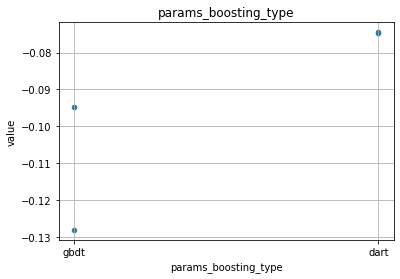

<Figure size 432x288 with 0 Axes>

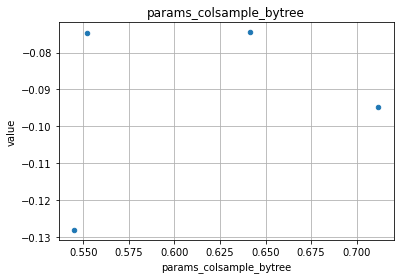

<Figure size 432x288 with 0 Axes>

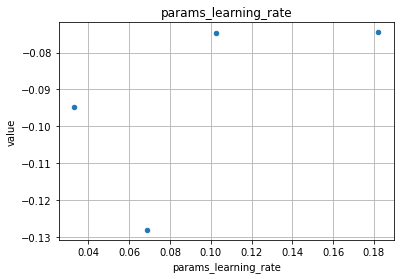

<Figure size 432x288 with 0 Axes>

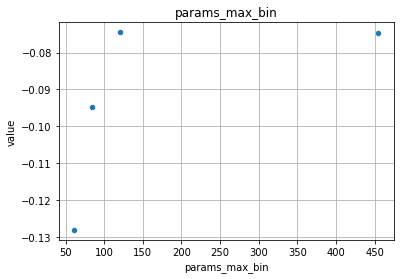

<Figure size 432x288 with 0 Axes>

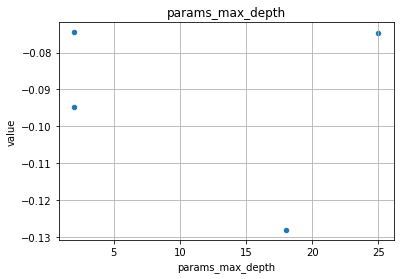

<Figure size 432x288 with 0 Axes>

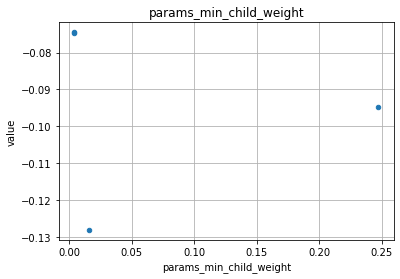

<Figure size 432x288 with 0 Axes>

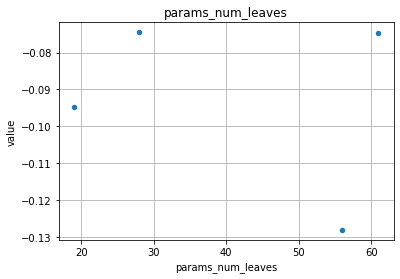

<Figure size 432x288 with 0 Axes>

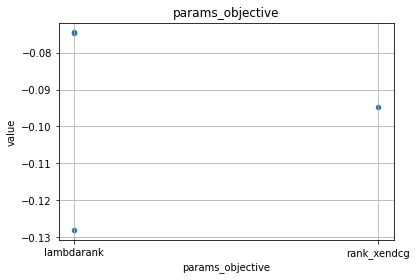

<Figure size 432x288 with 0 Axes>

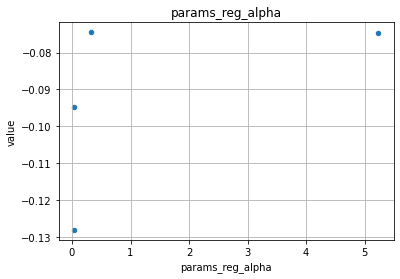

<Figure size 432x288 with 0 Axes>

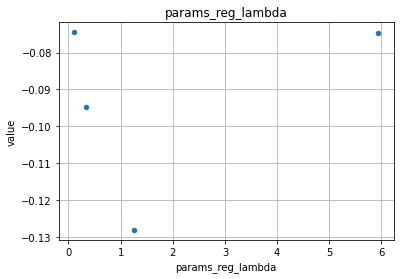

<Figure size 432x288 with 0 Axes>

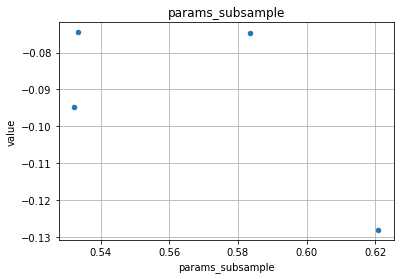

<Figure size 432x288 with 0 Axes>

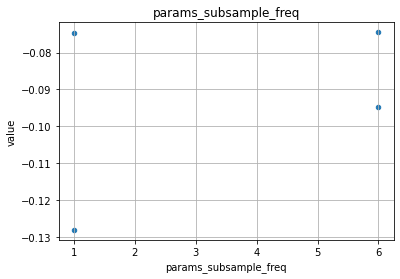

CPU times: user 23h 11min 58s, sys: 1min 15s, total: 23h 13min 14s
Wall time: 5h 54min 18s


In [15]:
%%time
'''
Hyperparameter tuning
'''
if RUN_HP:
    # run optimization
    best_params = optimize_hp()
    
else:
    # if not running HP, use pre-set best parameters
    best_params = BEST_PARAMS

In [16]:
'''
Re-fit best model
'''
params = {'selected_feats': selected_feats, 
          'lgbm_var_params': best_params.copy(), 
          'lgbm_fixed_params': LGBM_FIXED_PARAMS, 
          'n_estimators': N_ESTIMATORS_REFIT, 
          'early_stopping_rounds': EARLY_STOPPING_ROUNDS_REFIT}

outputs = []
for fold in range(N_FOLD):
    outputs.append(train_model(fold, params, 'normal'))
    
cv_score = np.mean([x['best_score_'] for x in outputs])
cv_sharpe = np.mean([x['sharpe']['val'] for x in outputs])
log(f"Folds best iterations: {[x['best_iteration_'] for x in outputs]}")
log(f"Folds average num unique values in train: {[x['n_uniq_trn'] for x in outputs]}")
log(f"Folds average num unique values in validation: {[x['n_uniq_val'] for x in outputs]}")
log(f"Folds scores: {[x['best_score_'] for x in outputs]}")
log(f"Folds sharpes: {[x['sharpe']['val'] for x in outputs]}")
log(f'CV score: {cv_score}')
log(f'CV sharpe: {cv_sharpe}')

[2022-06-18 23:13:05] Folds best iterations: [32, 80, 9, 116, 143]
[2022-06-18 23:13:05] Folds average num unique values in train: [1654.6791666666666, 1732.825, 1114.6875, 1806.8041666666666, 1861.0291666666667]
[2022-06-18 23:13:05] Folds average num unique values in validation: [1570.4, 1835.4833333333333, 1534.3166666666666, 1858.2666666666667, 1882.95]
[2022-06-18 23:13:05] Folds scores: [0.588413817722381, 0.5832997494304778, 0.5831073984999975, 0.5892221789691224, 0.5975328429368023]
[2022-06-18 23:13:05] Folds sharpes: [0.17514129718978058, 0.07256727325426568, 0.31137484609027094, -0.012146277048605424, 0.0935291506235233]
[2022-06-18 23:13:05] CV score: 0.5883151975117562
[2022-06-18 23:13:05] CV sharpe: 0.12809325802184704


[2022-06-18 23:13:06] Average % in top 200: 0.07128333333333338
[2022-06-18 23:13:06] Average % in bottom 200: 0.13254999999999992
[2022-06-18 23:13:07] Mean long returns: 0.09610548850200074
[2022-06-18 23:13:07] Mean short returns: 0.03537752133923862
[2022-06-18 23:13:07] Mean net returns: 0.1314830098412393
[2022-06-18 23:13:08] Sharpe of long: 0.035761254085736986
[2022-06-18 23:13:08] Sharpe of short: 0.01943221900524751
[2022-06-18 23:13:08] Sharpe of net: 0.09137999219972064


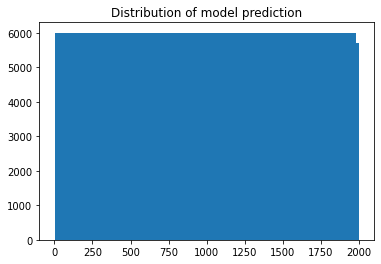

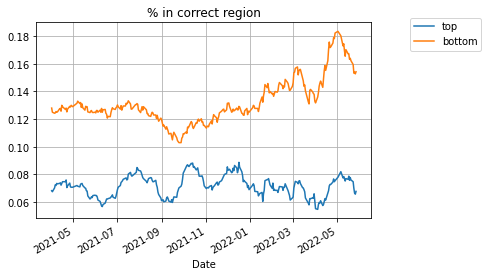

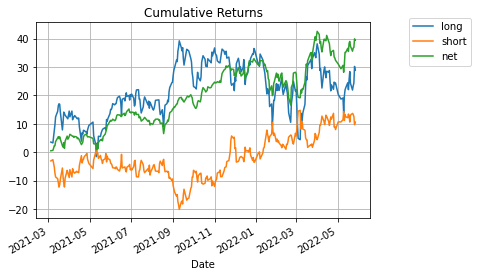

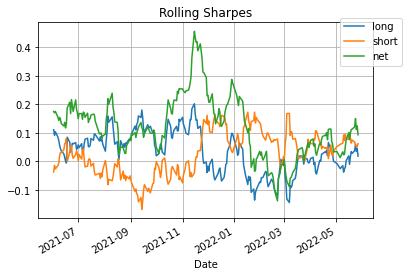

In [17]:
'''
Signal Analysis
'''
analyze_signal(outputs)

# Debug